In [1]:
import pygco
import numpy as np
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# generate a number of disparities as labels
def setDisparities1(maxDist, distStep):
    if distStep < 1:
        dists = np.array(range(0, int(maxDist*10000), int(distStep*10000)))
        dists = dists/10000
    else:   
        dists = np.array(range(0, maxDist, distStep))
    return dists

In [3]:
def getRgbDist(rgb1, rgb2):
    if(rgb1[0] > rgb2[0]):      
        rDiff = rgb1[0] - rgb2[0]
    else:
        rDiff = rgb2[0] - rgb1[0]
    if(rgb1[1] > rgb2[1]):      
        gDiff = rgb1[1] - rgb2[1]
    else:
        gDiff = rgb2[1] - rgb1[1]
    if(rgb1[2] > rgb2[2]):      
        bDiff = rgb1[2] - rgb2[2]
    else:
        bDiff = rgb2[2] - rgb1[2]
#     print((rDiff/3 + gDiff/3 + bDiff/3))
    return ((rDiff/3 + gDiff/3 + bDiff/3))

In [4]:
def buildGraphFromImages(imgs, dists, Ps):
    eta = 0.5*(dists[-1]-dists[0]) # max dist of neighboring labels
    sigmaC = 10 # tolerance data term
    epsilon = 500 # for lambda
    omegaS = 0.5*(dists[-1]-dists[0]) # smoothness strength
    
    img1 = imgs[0]
    imgs = imgs[1:]
    
    imgHeight = img1.shape[0] # range of vertical rows
    imgWidth = img1.shape[1] # range of horizontal columns
    
    nDists= dists.shape[0]
    # decompose P and P'
    K, R, T = Ps[0][0:3], Ps[0][3:6], Ps[0][6]
    neighborFrameParams = []
    for t in range(1, Ps.shape[0]):
        Kp, Rp, Tp = Ps[t][0:3,:], Ps[t][3:6, :], Ps[t][6, :]
        mat2Temp = Kp.dot(np.transpose(Rp))
        mat1Temp = mat2Temp.dot(R).dot(np.linalg.inv(K))
        mat3Temp = mat2Temp.dot((T-Tp))
        neighborFrameParams.append([mat1Temp, mat3Temp])
#     neighborFrameParams = np.array(neighborFrameParamsList)
    print("neighborFrameParams:")
    print(len(neighborFrameParams))
    
    #     print(Kp, Rp, Tp)
    # get prior term matrix/ pairwiseCost:
    pairwiseCost = np.zeros((nDists, nDists))
    for i in range(0, nDists):
        for j in range(0, nDists):
            pairwiseCost[i][j] = min(abs(dists[i]-dists[j]),eta)

    nNodes = imgHeight*imgWidth
    nEdges = (2*imgHeight*imgWidth-imgHeight-imgWidth)
    
    edges = np.zeros((nEdges, 2))
    edgeWeights = np.ones((nEdges))*(2/(255 + epsilon))
    unaryCosts = np.zeros((nNodes, nDists))
#     print(unaryCosts)
    
    # data cost /= smoothness prior
    # for each pixel x' on img1, get corresponded x'.
    edgeIndex = 0;
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            # build the graph from right and bottom neighbor to all pixels;
            nodeNo = r*imgWidth+c
            rightNodeNo = nodeNo+1
            bottomNodeNo = nodeNo+imgWidth
#             leftNode = nodeNo-1
#             topNode = nodeNo-imgWidth
            
            nodeRGB = img1[r, c]
            if(r > 0 and c > 0 and r < imgHeight-1 and c < imgWidth-1):
                neighborhoodSize = 4
                ULambda = (neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c+1]) + epsilon)) # right neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r+1, c]) + epsilon))# down neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c-1]) + epsilon))# left neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r-1, c]) + epsilon))# up neighbor
            elif(r == 0 and c > 0 and c < imgWidth-1):
                neighborhoodSize = 3
                ULambda = (neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c+1]) + epsilon)) # right neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r+1, c]) + epsilon))# down neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c-1]) + epsilon))# left neighbor 
            elif(c == 0 and r > 0 and r < imgHeight-1):
                neighborhoodSize = 3
                ULambda = (neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c+1]) + epsilon)) # right neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r+1, c]) + epsilon))# down neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r-1, c]) + epsilon))# up neighbor
            elif(r == imgHeight-1 and c >0 and c< imgWidth-1):
                neighborhoodSize = 3
                ULambda = (neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c+1]) + epsilon)) # right neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c-1]) + epsilon))# left neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r-1, c]) + epsilon))# up neighbor
            elif(c == imgWidth-1 and r >0 and r< imgHeight-1):
                neighborhoodSize = 3
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r+1, c]) + epsilon))# down neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c-1]) + epsilon))# left neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r-1, c]) + epsilon))# up neighbor
            elif(r == 0 and c == 0):
                neighborhoodSize = 2
                ULambda = (neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c+1]) + epsilon)) # right neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r+1, c]) + epsilon))# down neighbor
            elif(r ==0  and c == imgWidth -1):
                neighborhoodSize = 2
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r+1, c]) + epsilon))# down neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c-1]) + epsilon))# left neighbor
            elif(r == imgHeight-1 and c ==0):
                neighborhoodSize = 2
                ULambda = (neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c+1]) + epsilon)) # right neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r-1, c]) + epsilon))# up neighbor
            else:
                neighborhoodSize = 2
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c-1]) + epsilon))# left neighbor
                ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r-1, c]) + epsilon))# up neighbor
#             elif(r == imgHeight-1 and c == imgWidth-1):
#                 neighborhoodSize = 2
#                 ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r, c-1]) + epsilon))# left neighbor
#                 ULambda = ULambda+(neighborhoodSize/(getRgbDist(nodeRGB, img1[r-1, c]) + epsilon))# up neighbor
            if(rightNodeNo < nNodes and c < imgWidth-1): # update edge and edgeweights
                neighborRGB = img1[r, c+1]
                edges[edgeIndex,:] = np.array([nodeNo, rightNodeNo]) # update edge
                edgeWeights[edgeIndex] = omegaS*(ULambda/(getRgbDist(nodeRGB, neighborRGB) + epsilon))
                edgeIndex+=1
            if(bottomNodeNo < nNodes and r < imgHeight-1):
                neighborRGB = img1[r+1, c]
                edges[edgeIndex,:] = np.array([nodeNo, bottomNodeNo])
                edgeWeights[edgeIndex] = omegaS*(ULambda/(getRgbDist(nodeRGB, neighborRGB) + epsilon))
                edgeIndex+=1
            # unary cost /= data term:
            for t in range(0, len(neighborFrameParams)):
                mat1 = neighborFrameParams[t][0]
                mat3 = neighborFrameParams[t][1]
                img2 = imgs[t]
                for i in range(0, nDists):
                    dist = dists[i]
                    # make inhomogeneous coordinate of x:
                    x = np.array([r, c, 1])
                    xInfinite = mat1.dot(x)
                    if(xInfinite[2] != 0):
                        xInfinite = xInfinite/xInfinite[2]
                    ep = dist*mat3
                    xp = xInfinite + ep
                    # normalize x'
                    xp = xp/xp[2]
                    if (xp[0] < imgHeight and xp[0] >= 0 and xp[1] < imgWidth and xp[1] >= 0):
                        otherImgNodeRGB = img2[int(xp[0]), int(xp[1])]
                        rho = sigmaC /(getRgbDist(nodeRGB, otherImgNodeRGB)+sigmaC)
                        unaryCosts[nodeNo, i] = unaryCosts[nodeNo, i] + rho
                    else:
                        unaryCosts[nodeNo, i] = (sigmaC/(0+sigmaC))*(len(neighborFrameParams))
        
    return edges, edgeWeights, unaryCosts, pairwiseCost

In [5]:
# form an image from lables:
def formImg1(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    print(grayScaleStep)
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
#             print(label)
#             print(label*grayScaleStep)
            output[r][c] = (label*grayScaleStep)/255
    return output

In [6]:
P1 = np.array([[1221.2270770,0.0000000,479.5000000],
             [0.0000000,1221.2270770,269.5000000],
             [0.0000000,0.0000000,1.0000000],
             [1.0000000000,0.0000000000,0.0000000000],
             [0.0000000000,1.0000000000,0.0000000000],
             [0.0000000000,0.0000000000,1.0000000000],
             [0.0000000000,0.0000000000,0.0000000000]])

P2 = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9999996335,0.0008239030,0.0002328896],
               [-0.0008238827,0.9999996568,-0.0000873523],
               [-0.0002329615,0.0000871604,0.9999999691],
               [-1.0543652340,0.0331049274,0.1215278621]])

P3 = np.array([[1221.2270770,0.0000000,479.5000000],
             [0.0000000,1221.2270770,269.5000000],
             [0.0000000,0.0000000,1.0000000],
             [0.9999975979,0.0019555190,0.0009899857],
             [-0.0019550738,0.9999979874,-0.0004504099],
             [-0.0009908645,0.0004484733,0.9999994085],
             [-2.1749340190,0.0669574898,0.0331257801]])

P4 = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9999979521,0.0008588354,0.0018325390],
               [-0.0008574262,0.9999993362,-0.0007696360],
               [-0.0018331988,0.0007680632,0.9999980247],
               [-3.2682670464,0.0476771696,0.1722057556]])

P5 = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9999969136,0.0003604393,0.0024582397],
               [-0.0003573167,0.9999991290,-0.0012705751],
               [-0.0024586955,0.0012696928,0.9999961713],
               [-4.3753222466,0.0420169508,0.1947854925]])
Ps = np.array([P1, P5])
# Ps = np.array([P1, P2, P3, P4, P5])

In [7]:
MAX_DIST = 0.01
DIST_STEP = 0.0005

In [8]:
dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045
 0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009  0.0095]


In [9]:
img1 = cv2.imread('test0000.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('test0001.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread('test0002.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread('test0003.jpg')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.imread('test0004.jpg')
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)


# img6 = cv2.imread('test0005.jpg')
# img6 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

# imgs = np.array([img1, img2, img3, img4, img5])
imgs = np.array([img1, img5])

In [10]:
def initializeDepth(imgs, Ps, mLambda):
    imgsSize = imgs.shape[0]
    initLabels = []
    for i in range(0, imgsSize):
        # switch order of imgs
        imgTemp = imgs[i]
        imgs[i] = imgs[0]
        imgs[0] = imgTemp
        edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(imgs, dists, Ps)
        label = pygco.cut_general_graph(edges, mLambda*edgeWeights, unaryCosts, 1*pairwiseCost)
        initLabels.append(label)
    return initLabels

In [11]:
def bundleAdjustment(imgs, Ps, initLabels):
    # get distances candidates by N and e
    N = 15
    e = 0.0001
    distDiffs = np.array(range(0, int((N*e)*10000), int(e*10000)))
    distDiffs = distDiffs/10000
#     print(distDiffs)
    # data term
    
    # prior term

In [12]:
# # testing block:
# bundleAdjustment(imgs, Ps, labels)

In [13]:
mLambda = 1
initLabels = initializeDepth(imgs, Ps, mLambda)
finalLabels = bundleAdjustment()

In [14]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(imgs, dists, Ps)
# # print("pairwiseCost, unaryCosts")
# print("pairwiseCost:")
# print(pairwiseCost)
# print("unaryCost:")
# print(unaryCosts)

neighborFrameParams:
1


12.75


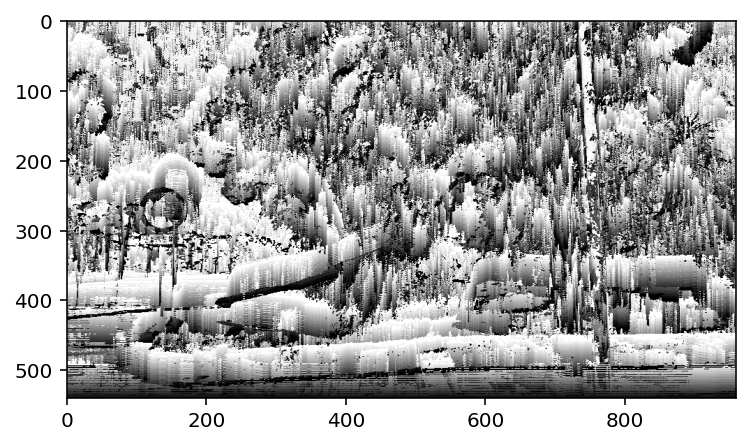

[11 11 11 ...  1  0 18]


In [15]:
mLambda = 1
labels = pygco.cut_general_graph(edges, mLambda*edgeWeights, unaryCosts, 1*pairwiseCost)
output = formImg1(img1, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

In [16]:
# output = formImg1(img1, dists, labels)
# plt.imshow(output/255, cmap = "gray")
# plt.show()
# print(labels)

In [17]:
# for i in range(0,unaryCosts.shape[0]):
#     for j in range(0, unaryCosts.shape[1]):
#         print(unaryCosts[i, j])

In [19]:
# for i in range(0,edgeWeights.shape[0]):
#     print(edgeWeights[i])